In [616]:
from pathlib import Path
import random

In [617]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:

from models.lfsr import LFSR
from models.pqmf import PQMF

def mtmt(x, lin):
    return lin(x.mT).mT

def nonlin(x):
    return torch.clamp(4*x, -1.0, 1.0)
def reluleak128(x):
    return F.leaky_relu(x, 1.0/128)
    
STEPS = 1
class FPGA_RC(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_bits = 4
        self.seed = 69
        self.register_buffer("feature_pushforward", self._gen_weights())
        self.register_buffer("feature", torch.zeros(8, 1))

    def _gen_weights(self):
        lfsr = LFSR(seed = self.seed)
        A = torch.tensor([lfsr.gen_fxp_shift(self.n_bits) for _ in range(64)]).reshape(8,8)
        return 0.1* A / torch.linalg.eigvals(A)[0].abs()

    def step(self, x, feat):
        pushed = nonlin(feat @ self.feature_pushforward.T + x)
        return pushed, torch.cat((pushed, reluleak128(pushed))).flatten()

    def forward(self, x, fin):
        out = torch.zeros(1, 16, 1)
        fout, o = self.step(x, fin)
        out[..., 0] = o
        return out, fout

In [ ]:


#FIXME: inherit finalpipe
class ONNXPipeline(TorchPipeline):
    def __init__(self, inorm_var, inorm_bias):
        super().__init__(FPGA_RC, inorm_var, inorm_bias)

    def forward(self, x, f):
        nbands = self.inorm_varscale.unsqueeze(-1) * (x - self.inorm_bias.unsqueeze(-1))

        nl_tdyn, fout = self.rc(nbands, f)

        ff = mtmt(nbands, self.ff)
        
        stacked = torch.cat((x, nbands, 
                             ff, nl_tdyn), dim=-2)

        assimilated = reluleak128(self.preact_norm(self.lin_out(stacked.mT)))

        return  assimilated.mean(dim=0), fout


In [ ]:
import warnings
from data.augmentations.randphase import AllPassFilter
from torch_audiomentations import *

#FIXME: update transforms
with warnings.catch_warnings(action="ignore"):
    # Initialize augmentation callable
    audio_aug = Compose(
        transforms = [
            PeakNormalization(p=1, output_type="dict"),
            Gain(min_gain_in_db = -1.2, max_gain_in_db=-0.8, p=1, output_type="dict")
            ],
            output_type="dict"
        )

In [ ]:
from data.torchfsdd.dataset import TorchFSDDGenerator
pqmf = PQMF(100, 8)
# Initialize a generator for a local version of FSDD
fsdd = TorchFSDDGenerator(
    version="local",
    path="/home/theloni/audio-rc-rtl/exploration/data/torchfsdd/recordings",
    val_transforms= lambda x: pqmf(audio_aug(x)["samples"]),
)
dset = fsdd.full()
b_rms = lambda x: x.pow(2).mean(dim=-1).mean(dim=-1).sqrt()
NOISE_PROB = 1 / 11
def collate_fn(batch):
    """Collects together sequences into a single batch, arranged in descending length order."""
    batch_size = len(batch)

    # Sort the (sequence, label) pairs in descending order of duration
    batch.sort(key=(lambda x: len(x[0])), reverse=True)
    # Shape: list(tuple(tensor(TxD), int))

    # Create list of sequences, and tensors for lengths and labels
    sequences, labels = [], torch.zeros(batch_size, dtype=torch.long)
    for i, (sequence, label) in enumerate(batch):
        labels[i] = label
        seq = sequence
        dice = random.random()
        if dice < NOISE_PROB:
            labels[i] = 10
            seq = pqmf(
                b_rms(seq).unsqueeze(-1).unsqueeze(-1)
                * torch.randn(seq.shape[0], 1, pqmf.n_band * seq.shape[-1])
            )
        sequences.append(seq)

    # Combine sequences into a padded matrix
    stacked_sequences = torch.cat(
        sequences, dim=0
    )  # torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    # Shape: (B x T_max x D)

    return stacked_sequences, labels

BSIZE = len(dset)
import torch.utils.data as data_utils
loader = data_utils.DataLoader(
        dset, collate_fn=collate_fn, batch_size=BSIZE
    )

In [622]:
X, y = next(iter(loader))

In [651]:
xin = F.instance_norm(X)
xbn = F.batch_norm(X, X.mean(dim=(0, -1)), X.var(dim=(0,-1)),training=False)

In [645]:
xcrms = X.pow(2).mean(dim=-1).sqrt()
xincrms = xin.pow(2).mean(dim=-1).sqrt()
print((xincrms.mean(dim=0), xincrms.std(dim=0)), (xcrms.mean(dim=0), xcrms.std(dim=0)))
in_v = X.var(dim=(2), unbiased=False).add(1e-5).sqrt().pow(-1)
in_m = X.mean(dim=(2))
(in_v.unsqueeze(-1)*(X -in_m.unsqueeze(-1)) - F.instance_norm(X)).abs().max(),(in_v.mean(dim=0), in_v.std(dim=0)), (in_m.mean(dim=0), in_m.std(dim=0))

(tensor([0.8925, 0.7848, 0.5847, 0.5716, 0.5106, 0.4942, 0.4415, 0.3451]), tensor([0.1715, 0.2684, 0.3201, 0.3282, 0.3191, 0.3019, 0.2986, 0.2796])) (tensor([0.0222, 0.0140, 0.0047, 0.0046, 0.0032, 0.0028, 0.0025, 0.0016]), tensor([0.0191, 0.0150, 0.0057, 0.0052, 0.0037, 0.0030, 0.0031, 0.0020]))


(tensor(1.9073e-06),
 (tensor([ 99.1305, 143.8697, 218.5743, 219.6412, 240.0760, 248.1646, 258.4194,
          278.1298]),
  tensor([ 87.0100, 102.5180,  88.2860,  91.2399,  78.2092,  69.8584,  69.4159,
           54.0525])),
 (tensor([-3.8014e-04, -1.7633e-05, -3.6144e-06,  3.0996e-06,  4.2845e-06,
          -3.0420e-07, -2.8768e-07,  1.6553e-06]),
  tensor([0.0009, 0.0011, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0001])))

In [ ]:
xcrms = X.pow(2).mean(dim=-1).sqrt()
xbncrms = xbn.pow(2).mean(dim=-1).sqrt()
print(xbncrms.mean(dim=0), xbncrms.std(dim=0))
print(xcrms.mean(dim=0), xcrms.std(dim=0))
b_v = X.var(dim=(2), unbiased=False).add(1e-5).sqrt().pow(-1)
b_m = X.mean(dim=(2))
(b_v.unsqueeze(-1)*(X -b_m.unsqueeze(-1)) - F.instance_norm(X)).abs().max(),(b_v.mean(dim=0), b_v.std(dim=0)), (b_m.mean(dim=0), b_m.std(dim=0))

tensor([0.7525, 0.6745, 0.5842, 0.5999, 0.5541, 0.5387, 0.4925, 0.3984]) tensor([0.6499, 0.7225, 0.7090, 0.6851, 0.6342, 0.5812, 0.6080, 0.4854])
tensor([0.0222, 0.0140, 0.0047, 0.0046, 0.0032, 0.0028, 0.0025, 0.0016]) tensor([0.0191, 0.0150, 0.0057, 0.0052, 0.0037, 0.0030, 0.0031, 0.0020])


(tensor(1.9073e-06),
 (tensor([ 99.1305, 143.8697, 218.5743, 219.6412, 240.0760, 248.1646, 258.4194,
          278.1298]),
  tensor([ 87.0100, 102.5180,  88.2860,  91.2399,  78.2092,  69.8584,  69.4159,
           54.0525])),
 (tensor([-3.8014e-04, -1.7633e-05, -3.6144e-06,  3.0996e-06,  4.2845e-06,
          -3.0420e-07, -2.8768e-07,  1.6553e-06]),
  tensor([0.0009, 0.0011, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0001])))

: 

In [ ]:
paramdict = {'bands': 8, 'bits': 4, 'spec_rad': 0.1}
uut_vmap =  TorchPipeline(VMAP_RC)

def load_model(m, folder, mdevice='cpu'):
    ckpt_path = Path(folder)
    fnames = [f.name for f in ckpt_path.iterdir() if f.is_file()]
    fpnames = [n.split(".ten")[0] for n in fnames]
    print(ckpt_path, "\n", fnames, "\n",fpnames)
    print("targeting", [n for n, _ in m.named_parameters()])
    epoch = int(folder.split("epoch")[-1])
    for pname, p in m.named_parameters():
        assert (
            pname in fpnames
        ), f"Unable to locate parameter {pname} in given checkpoint dir"
        loaded = torch.load(ckpt_path / fnames[fpnames.index(pname)]).to(mdevice)
        print("setting", pname, "to loaded value from", fnames[fpnames.index(pname)])
        p.data = loaded

    return epoch

/net/flood/home/theloni/audio-rc-rtl/exploration/models/lfsr.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.poly_degrees = torch.tensor(polydegrees)


In [626]:
with torch.no_grad():
    load_model(uut_vmap, "models/rc8.3/epoch299")
    uut_vmap.eval()

models/rc8.3/epoch299 
 ['ff1.bias.tensor', 'ff1.weight.tensor', 'ff2.bias.tensor', 'ff2.weight.tensor', 'lin_out.bias.tensor', 'lin_out.weight.tensor', 'preact_norm.bias.tensor', 'preact_norm.weight.tensor'] 
 ['ff1.bias', 'ff1.weight', 'ff2.bias', 'ff2.weight', 'lin_out.bias', 'lin_out.weight', 'preact_norm.bias', 'preact_norm.weight']
targeting ['ff1.weight', 'ff1.bias', 'ff2.weight', 'ff2.bias', 'lin_out.weight', 'lin_out.bias', 'preact_norm.weight', 'preact_norm.bias']
setting ff1.weight to loaded value from ff1.weight.tensor
setting ff1.bias to loaded value from ff1.bias.tensor
setting ff2.weight to loaded value from ff2.weight.tensor
setting ff2.bias to loaded value from ff2.bias.tensor
setting lin_out.weight to loaded value from lin_out.weight.tensor
setting lin_out.bias to loaded value from lin_out.bias.tensor
setting preact_norm.weight to loaded value from preact_norm.weight.tensor
setting preact_norm.bias to loaded value from preact_norm.bias.tensor


In [627]:
uut_vmap, [(n,p.numel(), p.device, p.data) for n,p in uut_vmap.named_parameters()], [(n,b.data) for n,b in uut_vmap.named_buffers()], 

(TorchPipeline(
   (rc): VMAP_RC()
   (ff1): Linear(in_features=8, out_features=24, bias=True)
   (ff2): Linear(in_features=24, out_features=16, bias=True)
   (lin_out): Linear(in_features=48, out_features=11, bias=True)
   (preact_norm): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 [('ff1.weight',
   192,
   device(type='cpu'),
   tensor([[-2.1504e-02,  1.2400e-01, -7.6970e-01,  4.4548e+00, -1.1558e-01,
            -1.1768e-02, -6.2711e-01, -6.5044e-01],
           [ 9.7532e-01,  2.2537e-01,  1.2142e+00, -1.7328e+00,  1.8067e-01,
            -8.9448e-01, -1.5824e+00, -4.7276e-01],
           [ 4.5275e-02,  1.1039e-02, -2.5860e-01,  1.1913e-01,  5.9513e-01,
            -1.1426e+00, -3.8887e+00, -1.5814e-01],
           [ 2.7645e+00, -2.8629e-01, -4.1546e-01, -2.1212e-01, -3.0485e-01,
            -7.4737e-01, -6.2485e-01,  4.9044e-01],
           [ 4.4505e-01,  8.0412e-02, -2.4448e-01,  3.9581e-01,  1.0937e+00,
            -3.6632e+00,  1.6360e-01

In [628]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

pltr = lambda x: x.cpu().detach().numpy()

In [629]:
batched_uut = torch.vmap(uut_vmap)
# batched_uut = uut_vmap
acc = []
Xs,ys,yhats=[],[],[]
def testcpu():
    batches=0
    for X, y in loader:
        if X.shape[0] != BSIZE:
            continue
        Xs.append(X)
        ys.append(y)
        yhat = batched_uut(X)
        yhats.append(yhat)
        acc.append((yhat.argmax(-1) == y).sum() / y.numel())
        batches += 1
    return sum(acc)/batches

acc = testcpu()
X, y, yhat = map(torch.cat, (Xs, ys, yhats))
acc, X.shape, y.shape, yhat.shape

(tensor(0.0896),
 torch.Size([2979, 8, 1024]),
 torch.Size([2979]),
 torch.Size([2979, 11]))

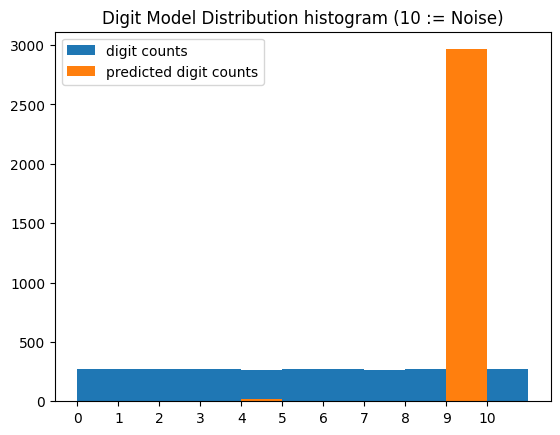

In [631]:
def plothist():
    f, ax = plt.subplots()

    ax.set_title("Digit Model Distribution histogram (10 := Noise)")
    ax.hist(pltr(y.flatten()), bins=np.arange(0, 11 + 1, 1), label="digit counts")
    ax.hist(
            pltr(yhat.argmax(1).flatten()), bins=np.arange(0, 11 + 1, 1), label="predicted digit counts"
        )
    ax.set_xticks(list(map(float, range(11))))
    ax.legend()
    plt.show()
plothist()

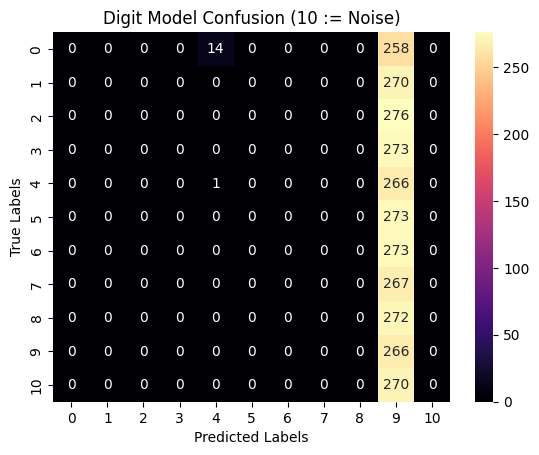

In [632]:
def plotconf():
        pred = pltr(yhat.argmax(1).flatten())
        # Compute confusion matrix
        cm = confusion_matrix(pltr(y.flatten()), pred)

        # Plot confusion matrix
        f, ax = plt.subplots()
        ax.set_title("Digit Model Confusion (10 := Noise)")

        sns.heatmap(
                cm,
                annot=True,
                fmt="d",
                cmap="magma",
                xticklabels=np.unique(pltr(y)),
                yticklabels=np.unique(pltr(y)),
                ax=ax,
        )
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")

        plt.show()
plotconf()

In [633]:
uut_fpga = ONNXPipeline(v, m)

/net/flood/home/theloni/audio-rc-rtl/exploration/models/lfsr.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.poly_degrees = torch.tensor(polydegrees)


AttributeError: 'ONNXPipeline' object has no attribute 'in_norm'

In [ ]:
with torch.no_grad():
    load_model(uut_fpga, "models/rc8.3/epoch299")
    uut_fpga.eval()


models/rc8.3/epoch299 
 ['ff1.bias.tensor', 'ff1.weight.tensor', 'ff2.bias.tensor', 'ff2.weight.tensor', 'lin_out.bias.tensor', 'lin_out.weight.tensor', 'preact_norm.bias.tensor', 'preact_norm.weight.tensor'] 
 ['ff1.bias', 'ff1.weight', 'ff2.bias', 'ff2.weight', 'lin_out.bias', 'lin_out.weight', 'preact_norm.bias', 'preact_norm.weight']
targeting ['ff1.weight', 'ff1.bias', 'ff2.weight', 'ff2.bias', 'lin_out.weight', 'lin_out.bias', 'preact_norm.weight', 'preact_norm.bias']
setting ff1.weight to loaded value from ff1.weight.tensor
setting ff1.bias to loaded value from ff1.bias.tensor
setting ff2.weight to loaded value from ff2.weight.tensor
setting ff2.bias to loaded value from ff2.bias.tensor
setting lin_out.weight to loaded value from lin_out.weight.tensor
setting lin_out.bias to loaded value from lin_out.bias.tensor
setting preact_norm.weight to loaded value from preact_norm.weight.tensor
setting preact_norm.bias to loaded value from preact_norm.bias.tensor


In [ ]:
uut_onnx = torch.onnx.dynamo_export(uut_fpga, torch.randn(1, 8, 1), torch.zeros(1, 8))

/home/theloni/miniconda/envs/iir-torch/lib/python3.11/site-packages/torch/onnx/_internal/exporter.py:130: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(


OnnxExporterError: Failed to export the model to ONNX. Generating SARIF report at 'report_dynamo_export.sarif'. SARIF is a standard format for the output of static analysis tools. SARIF logs can be loaded in VS Code SARIF viewer extension, or SARIF web viewer (https://microsoft.github.io/sarif-web-component/). Please report a bug on PyTorch Github: https://github.com/pytorch/pytorch/issues

In [ ]:
uut_onnx.save("2step_pipe.onnx")